# 1 PreI neuron

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone')
device.reinit()
device.activate()
# prefs.devices.cpp_standalone.openmp_threads = 2
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)', fontsize = 25)
    ylabel('Firing Rate', fontsize = 25)
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)', fontsize = 25)
            ylabel(str(list_of_params[i]), fontsize = 25)
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations


eqs_general = '''
dv/dt = (- INa  -INaP - IK  - Il - IsynE - IsynI - ICaL - IK_Ca + Iapp)/C :volt #
Iapp : amp
ENa = 55*mV :volt
EK = -94*mV :volt
C = 36*pF :farad
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp
dmK/dt = (m_inf_K - mK)/tau_mK :1
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1     
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second
tau_mK_max = 1*ms :second
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1
tau_hNa = tau_hNa_max/cosh((v+hNa_v_half*mV)/(tauhNa_var*mV)) :second
h_inf_Na = 1/(1+exp((v+hNa_v_half*mV)/(hNa_k*mV))) :1
hNa_v_half = 67.5 : 1
hNa_k = 10.8 :1
tau_hNa_max = 8.456*ms :second
tauhNa_var  = 12.8 :1
mNa_v_half = 43.8 :1
mNa_k = 6 :1
taumNa_var = 14:1

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1
m_inf_Na = 1/(1+exp(-(v+mNa_v_half*mV)/(mNa_k*mV))) :1
tau_mNa =  tau_mNa_max/cosh(-(v+mNa_v_half*mV)/(taumNa_var*mV)) : second  
tau_mNa_max = 0.252*ms :second
'''


eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1
dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second         
tau_mNaP_max = 1*ms :second
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1 
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second 
tau_hNaP_max = 5000*ms :second #6000

'''

eqs_Il = '''
Il = gl*(v-El) :amp
El : volt
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*h_inf_CaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp
gE = 1*nS : siemens
gEd = 1*nS : siemens
tau_synE = 30*ms :second
EsynE = 0*mV :volt
dwE/dt = -wE/tau_synE :1  #from self


# IsynI current
IsynI = gsynI*(v-EsynI) : amp
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens
gId = 1*nS : siemens
gI = 1*nS : siemens
tau_synI = 15*ms :second
EsynI = -75*mV :volt
dwI_1/dt = -wI_1/tau_synI :1 
dwI_2/dt = -wI_2/tau_synI :1 
dwI_3/dt = -wI_3/tau_synI :1 
''' 
 
eqs = eqs_general+eqs_IK+eqs_INa+eqs_INaP+eqs_Il+ eqs_IK_Ca +eqs_ICaL+eqs_ICaT + eqs_syn
        

In [3]:
N = 1 #number of neurons in a population
#################################################
#adding specific equations for a population

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.29) :siemens # 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons #+ 0.28 is threshold 1 +0.4*t/60000/ms
gK_Ca  = 0*nS : siemens #+ +0.3*t/60000/ms
gCaL = 0*nS : siemens #+
gNa = 170*nS :siemens #+
gNaP = 5*nS :siemens #+
gK = 180*nS :siemens #+
gl = 2.5*nS :siemens #+
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV', refractory='v >= -35*mV') #+ 
PreI.v = (-68+10*randn(1,N))*mV 
PreI.El = (-68+0.136*randn(1,N))*mV  #+
PreI.mNaP = rand(1,N) #+
PreI.hNaP = rand(1,N) #+
PreI.hNa = rand(1,N) #+
PreI.mNa = rand(1,N) #+
PreI.mK = rand(1,N) #+

In [4]:
PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.1') #+
PreI_PreI.connect(p=1)
PreI_PreI.delay = 5*rand(1,N)*ms

In [5]:
PreI_statemon = StateMonitor(PreI, ['v','wE'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

In [6]:
duration = 15000
run(duration*ms, report='text')


In [7]:
n = 0.20
m = 0.6

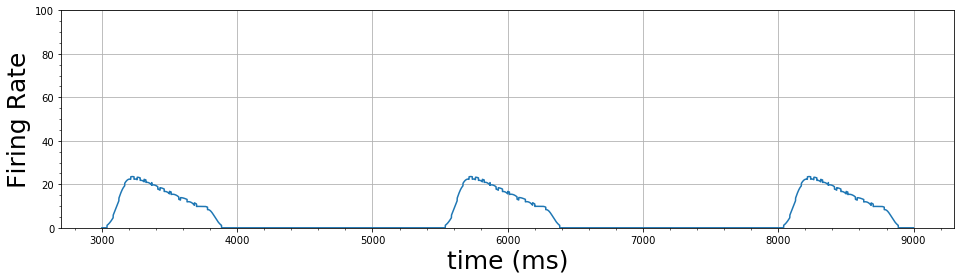

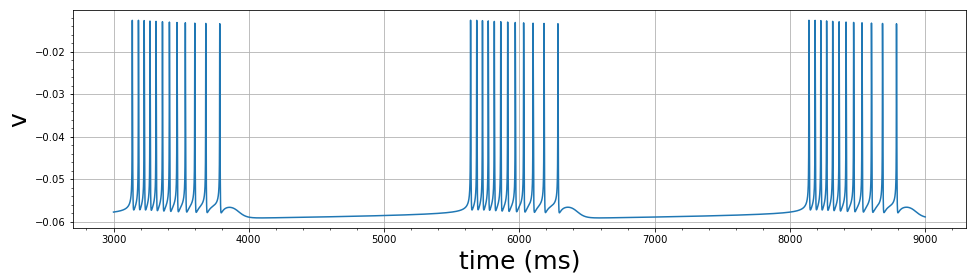

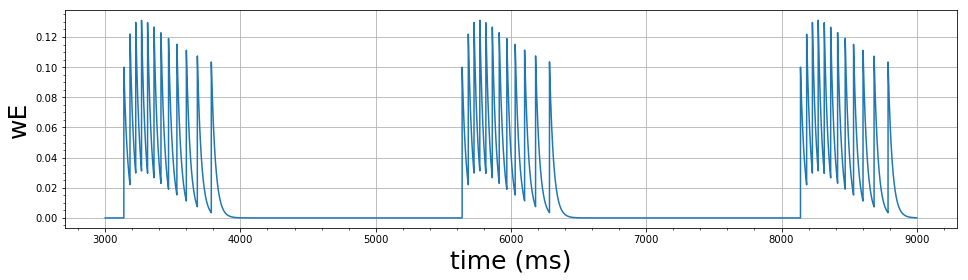

In [8]:
#PreI
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = True)

#### 1 "other" neuron

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone', build_on_run=False)
# prefs.devices.cpp_standalone.openmp_threads = 2
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations
from brian2 import *
import numpy as np
import pickle
import pandas as pd
start_scope()


eqs_general = '''
dv/dt = (- INa  -INaP - IK - ICaL - ICaT- IK_Ca - Il - IsynE - IsynI + Iapp)/C :volt #+
Iapp : amp
ENa = 55*mV :volt #+
EK = -94*mV :volt #+
C = 36*pF :farad #+
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp #+
dmK/dt = (m_inf_K - mK)/tau_mK :1 #+
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1    #+  
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1 #+
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1 #+
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second #+
tau_mK_max = 1*ms :second #+
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp #+

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1 #+
tau_hNa = tau_hNa_max/cosh((v + 67.5*mV)/(12.8*mV)) :second  #+
h_inf_Na = 1/(1+exp((v+67.5*mV)/(10.8*mV))) :1 #+
tau_hNa_max = 8.456*ms :second #+

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1 #+
m_inf_Na = 1/(1+exp(-(v+ 43.8*mV)/(6*mV))) :1 #+
tau_mNa =  tau_mNa_max/cosh(-(v+ 43.8*mV)/(14*mV)) : second  #+
tau_mNa_max = 0.252*ms :second #+
'''

eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp #+

dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1 #+
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 #+ 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second  #+       
tau_mNaP_max = 1*ms :second #+

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1 #+
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1  #+
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second #+
tau_hNaP_max = 5000*ms :second #+

'''

eqs_Il = '''
Il = gl*(v-El) :amp #+
El : volt #+
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 5*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


# eqs_ICaL = '''
# ICaL = gCaL*mCaL*hCaL*(v-ECa) :amp #+

# dhCaL/dt = (h_inf_CaL - hCaL)/tau_hCaL :1 #+
# dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
# m_inf_CaL = 1/(1+exp(-(v+27.4*mV)/(5.7*mV))) :1 #+
# h_inf_CaL = 1/(1+exp((v+52.4*mV)/(5.2*mV))) :1 #+
# tau_mCaL = 0.5*ms :second #+
# tau_hCaL = 18*ms :second #+

# '''

# eqs_IK_Ca = '''
# IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

# dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
# alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
# beta_inf_K_Ca = 2.5 : 1 #+
# m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
# tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
# tau_mK_Ca_max = 1*ms :second      #+ (1-8)                                            

# Pb = B/(Ca+B+K) :1 #+
# ECa = 13.27*mV*log(4*mM/Ca_0) :volt #+
# dCa/dt =  (Ca_0 - Ca)/tau_Ca : mM  #+ 0*k_Ca*ICaL*(1-Pb) +
# tau_Ca = 500*ms :second 

# k_Ca = 5.18*10**(-9)*mM/(amp*second) : mM/amp/second #!!
# B = 0.030*mM : mM #+
# K = 0.001*mM : mM #+
# Ca_0 = (5*10**(-5))*mM : mM #+

# '''

# eqs_ICaT = '''
# mCaT : 1
# hCaT : 1
# '''

eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp #+
gE = 1*nS : siemens #+
gEd = 1*nS : siemens #+
tau_synE = 5*ms :second #+
EsynE = 0*mV :volt #+
dwE/dt = -wE/tau_synE :1  #from self #+


# IsynI current
IsynI = gsynI*(v-EsynI) : amp #+
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens #+
gId = 1*nS : siemens #+
gI = 1*nS : siemens #+
tau_synI = 15*ms :second #+
EsynI = -75*mV :volt #+
dwI_1/dt = -wI_1/tau_synI :1  #+
dwI_2/dt = -wI_2/tau_synI :1  #+
dwI_3/dt = -wI_3/tau_synI :1  #+
''' 
 
eqs = eqs_general+eqs_IK+eqs_INa+eqs_INaP+eqs_Il+eqs_IK_Ca+eqs_ICaL + eqs_syn + eqs_ICaT
        

In [3]:
N = 1 #number of neurons in a population
#################################################
#adding specific equations for a population

EarlyI1_eqs = eqs + '''
x : 1
gsynE = gE*(wE) + gEd*(x) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method = 'exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') # method = 'exponential_euler'
EarlyI1.v = (-60+3*randn(1,N))*mV
EarlyI1.El = (-60+0.93*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [4]:
EarlyI1_statemon = StateMonitor(EarlyI1, ['v','x','Ca','ICaL'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

In [5]:
duration = 13000
EarlyI1.x = 0.0
run(1000*ms, report='text')
EarlyI1.x = 0.6
run(3000*ms, report='text')
EarlyI1.x = 0.0
run(1000*ms, report='text')
EarlyI1.x = 1
run(3000*ms, report='text')
EarlyI1.x = 0.0
run(1000*ms, report='text')
EarlyI1.x = 1.7
run(3000*ms, report='text')
EarlyI1.x = 0.0
run(1000*ms, report='text')
device.build(directory='output', compile=True, run=True, debug=False)

In [6]:
n = 0.1
m = 0.95

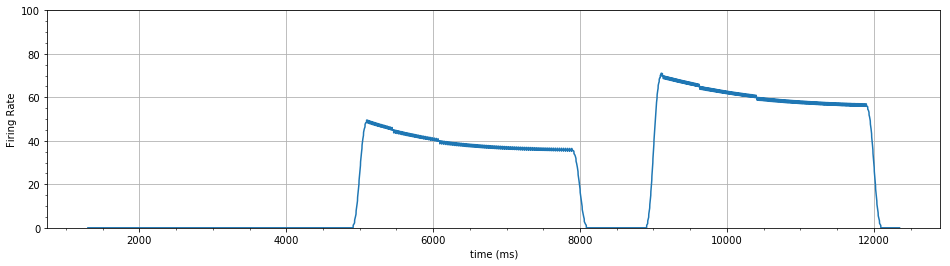

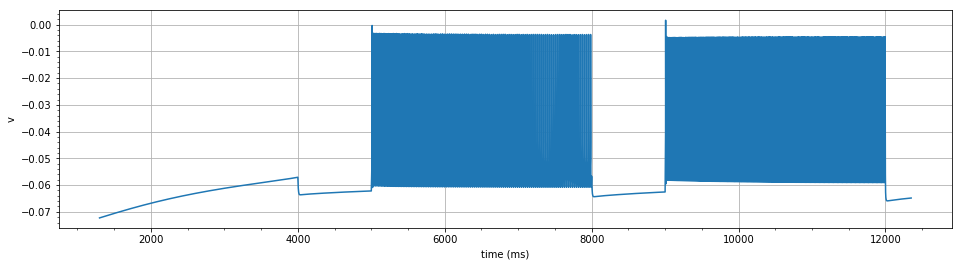

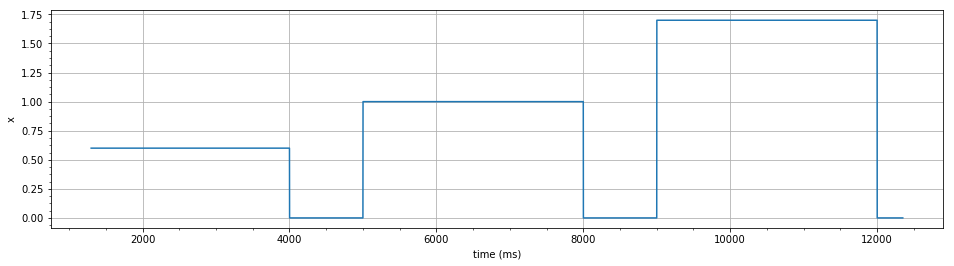

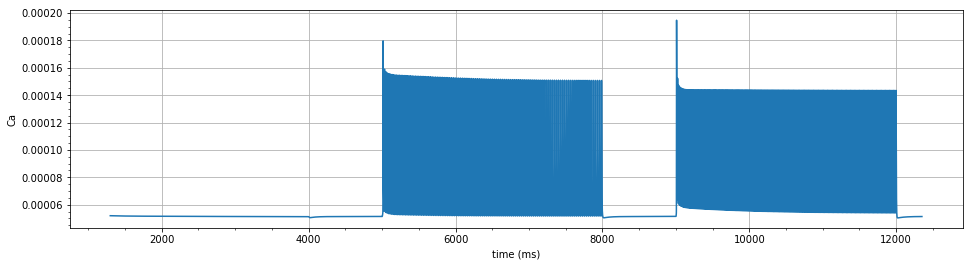

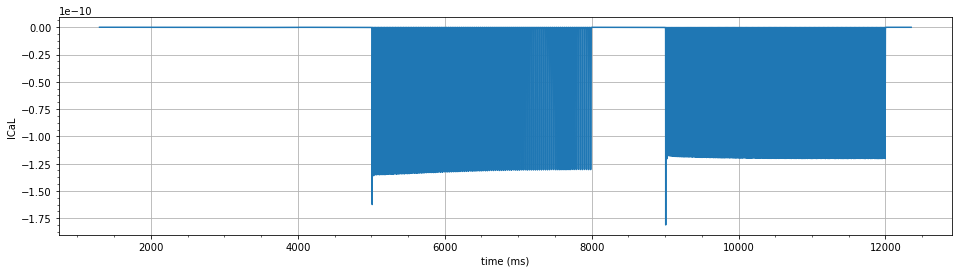

In [7]:
#EarlyE1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = True)

# Half-centred oscillator

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone')
device.reinit()
device.activate()
# prefs.devices.cpp_standalone.openmp_threads = 2
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)', fontsize = 25)
    ylabel('Firing Rate', fontsize = 25)
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)', fontsize = 25)
            ylabel(str(list_of_params[i]), fontsize = 25)
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations
from brian2 import *
import numpy as np
import pickle
import pandas as pd
start_scope()


eqs_general = '''
dv/dt = (- INa  -INaP - IK  - Il - IsynE - IsynI -ICaL - IK_Ca + Iapp)/C :volt #
Iapp : amp
ENa = 55*mV :volt
EK = -94*mV :volt
C = 36*pF :farad
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp
dmK/dt = (m_inf_K - mK)/tau_mK :1
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1     
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second
tau_mK_max = 1*ms :second
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1
tau_hNa = tau_hNa_max/cosh((v+hNa_v_half*mV)/(tauhNa_var*mV)) :second
h_inf_Na = 1/(1+exp((v+hNa_v_half*mV)/(hNa_k*mV))) :1
hNa_v_half = 67.5 : 1
hNa_k = 10.8 :1
tau_hNa_max = 8.456*ms :second
tauhNa_var  = 12.8 :1
mNa_v_half = 43.8 :1
mNa_k = 6 :1
taumNa_var = 14:1

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1
m_inf_Na = 1/(1+exp(-(v+mNa_v_half*mV)/(mNa_k*mV))) :1
tau_mNa =  tau_mNa_max/cosh(-(v+mNa_v_half*mV)/(taumNa_var*mV)) : second  
tau_mNa_max = 0.252*ms :second
'''


eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1
dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second         
tau_mNaP_max = 1*ms :second
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1 
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second 
tau_hNaP_max = 5000*ms :second #6000

'''

eqs_Il = '''
Il = gl*(v-El) :amp
El : volt
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp
gE = 1*nS : siemens
gEd = 1*nS : siemens
tau_synE = 5*ms :second
EsynE = 0*mV :volt
dwE/dt = -wE/tau_synE :1  #from self


# IsynI current
IsynI = gsynI*(v-EsynI) : amp
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens
gId = 1*nS : siemens
gI = 1*nS : siemens
tau_synI = 15*ms :second
EsynI = -75*mV :volt
dwI_1/dt = -wI_1/tau_synI :1 
dwI_2/dt = -wI_2/tau_synI :1 
dwI_3/dt = -wI_3/tau_synI :1 
''' 
 
eqs = eqs_general + eqs_IK + eqs_INa + eqs_INaP + eqs_Il + eqs_IK_Ca + eqs_ICaL + eqs_ICaT + eqs_syn
        

In [3]:
N = 1 #number of neurons in a population
#################################################

EarlyI1_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI1.v = (-60+0.3*randn(1,N))*mV
EarlyI1.El = (-60+0.093*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

AugE_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1) :siemens # 0 + 1 + 0.4
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

AugE = NeuronGroup(N, AugE_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
AugE.v = (-60+0.3*randn(1,N))*mV
AugE.El = (-60+0.093*randn(1,N))*mV 
AugE.mNaP = rand(1,N)
AugE.hNaP = rand(1,N)
AugE.hNa = rand(1,N)
AugE.mNa = rand(1,N)
AugE.mK = rand(1,N)
AugE.mK_Ca = rand(1,N)
AugE.mCaL = rand(1,N)
AugE.mCaT = rand(1,N)
AugE.hCaT = rand(1,N)
AugE.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [4]:
EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)
AugE.Iapp = 0

AugE_EarlyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_2_post += 3') #0.025 0.145
AugE_EarlyI1.connect(p=1)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_2_post += 3') # 0.02 0.115
EarlyI1_AugE.connect(p=1)


In [5]:
duration = 20000
run(20000*ms, report='text')
#device.build(directory='output', compile=True, run=True, debug=False)

In [6]:
n = 5.0/20.0
m = 1.0

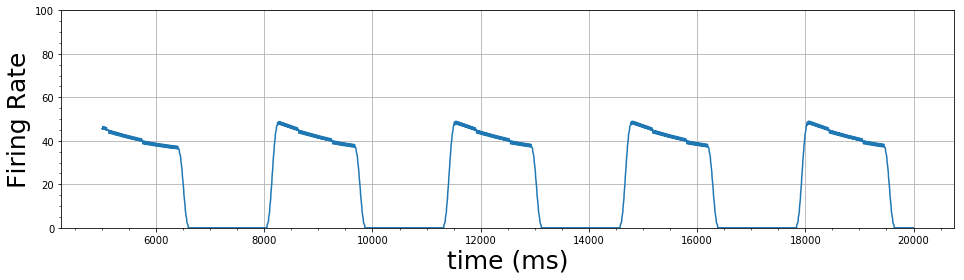

In [7]:
### AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

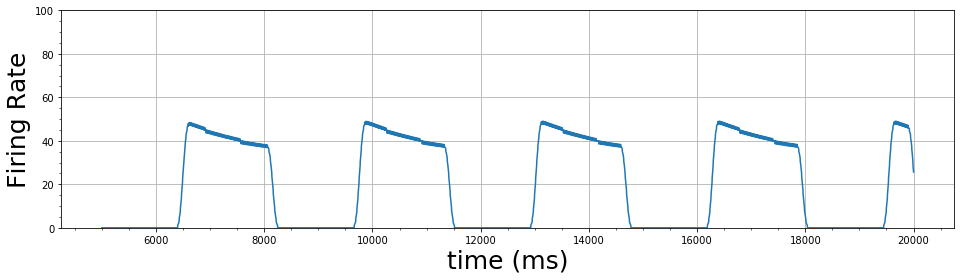

In [8]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

# Medullary model

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone')
device.reinit()
device.activate()
# prefs.devices.cpp_standalone.openmp_threads = 2
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations


eqs_general = '''
dv/dt = (- INa  -INaP - IK  - Il - IsynE - IsynI -ICaL - IK_Ca + Iapp)/C :volt #
Iapp : amp
ENa = 55*mV :volt
EK = -94*mV :volt
C = 36*pF :farad
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp
dmK/dt = (m_inf_K - mK)/tau_mK :1
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1     
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second
tau_mK_max = 1*ms :second
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1
tau_hNa = tau_hNa_max/cosh((v+hNa_v_half*mV)/(tauhNa_var*mV)) :second
h_inf_Na = 1/(1+exp((v+hNa_v_half*mV)/(hNa_k*mV))) :1
hNa_v_half = 67.5 : 1
hNa_k = 10.8 :1
tau_hNa_max = 8.456*ms :second
tauhNa_var  = 12.8 :1
mNa_v_half = 43.8 :1
mNa_k = 6 :1
taumNa_var = 14:1

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1
m_inf_Na = 1/(1+exp(-(v+mNa_v_half*mV)/(mNa_k*mV))) :1
tau_mNa =  tau_mNa_max/cosh(-(v+mNa_v_half*mV)/(taumNa_var*mV)) : second  
tau_mNa_max = 0.252*ms :second
'''


eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1
dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second         
tau_mNaP_max = 1*ms :second
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1 
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second 
tau_hNaP_max = 5000*ms :second #6000

'''

eqs_Il = '''
Il = gl*(v-El) :amp
El : volt
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp
gE = 1*nS : siemens
gEd = 1*nS : siemens
tau_synE = 5*ms :second
EsynE = 0*mV :volt
dwE/dt = -wE/tau_synE :1  #from self


# IsynI current
IsynI = gsynI*(v-EsynI) : amp
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens
gId = 1*nS : siemens
gI = 1*nS : siemens
tau_synI = 15*ms :second
EsynI = -75*mV :volt
dwI_1/dt = -wI_1/tau_synI :1 
dwI_2/dt = -wI_2/tau_synI :1 
dwI_3/dt = -wI_3/tau_synI :1 
''' 
 
eqs = eqs_general+eqs_IK+eqs_INa+eqs_INaP+eqs_Il+ eqs_IK_Ca +eqs_ICaL+eqs_ICaT + eqs_syn
        

In [3]:
N = 1 #number of neurons in a population
#################################################

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.27  + 0.3 + 0) :siemens # drive 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons 0.15
gK_Ca  = 0*nS : siemens
gCaL = 0*nS : siemens
gCaT = 0*nS : siemens
gNa = 170*nS :siemens
gNaP = 5*nS :siemens
gK = 180*nS :siemens
gl = 2.5*nS :siemens
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PreI.v = (-68+3*randn(1,N))*mV
PreI.El = (-68+0.136*randn(1,N))*mV #-68
PreI.mNaP = rand(1,N)
PreI.hNaP = rand(1,N)
PreI.hNa = rand(1,N)
PreI.mNa = rand(1,N)
PreI.mK = rand(1,N)

EarlyI1_eqs = eqs + '''
x : 1
gsynE = gE*(wE) + gEd*(0.8) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI1.v = (-60+0.3*randn(1,N))*mV
EarlyI1.El = (-60+0.093*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

AugE_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1) :siemens # 0 + 1 + 0.4
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

AugE = NeuronGroup(N, AugE_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
AugE.v = (-60+0.3*randn(1,N))*mV
AugE.El = (-60+0.093*randn(1,N))*mV 
AugE.mNaP = rand(1,N)
AugE.hNaP = rand(1,N)
AugE.hNa = rand(1,N)
AugE.mNa = rand(1,N)
AugE.mK = rand(1,N)
AugE.mK_Ca = rand(1,N)
AugE.mCaL = rand(1,N)
AugE.mCaT = rand(1,N)
AugE.hCaT = rand(1,N)
AugE.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [4]:
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)
AugE.Iapp = 0

PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.5') #0.03
PreI_PreI.connect(p=1)
PreI_PreI.delay = 4*rand(1,N)*ms

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 2') #0.034
PreI_EarlyI1.connect(p=1)#monitorings, spikes etc.

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 2') #0.025
AugE_PreI.connect(p=1)

AugE_EarlyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_2_post += 2.3') #0.025 0.145
AugE_EarlyI1.connect(p=1)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_2_post += 3.0') # 0.02 0.115
EarlyI1_AugE.connect(p=1)



In [5]:
duration = 25000
run(25000*ms, report='text')

In [6]:
n = (5.0/duration)*1000
m = 1.0

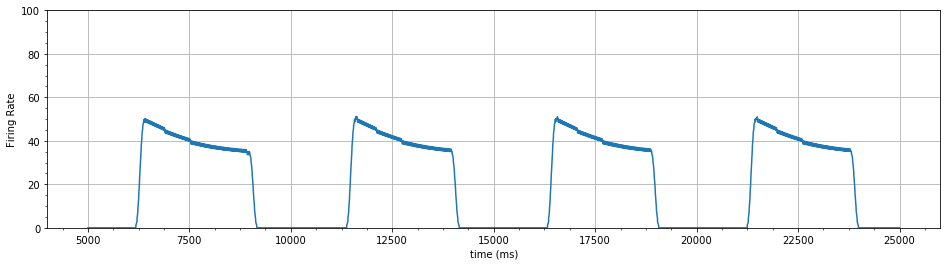

In [7]:
### AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

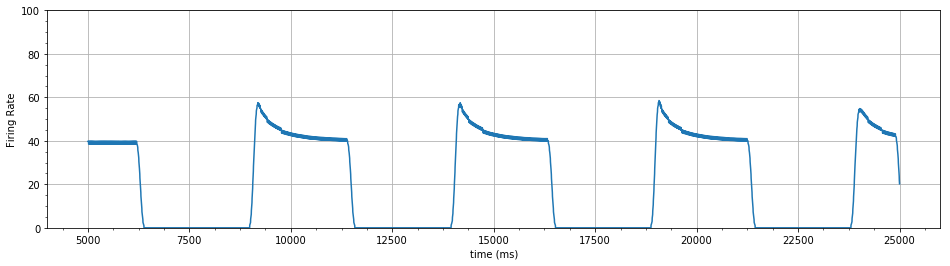

In [8]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

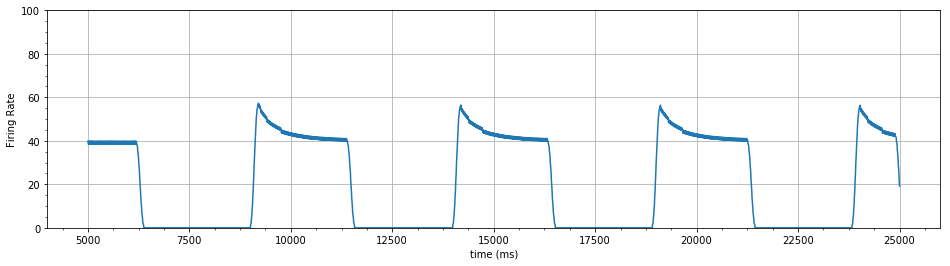

In [9]:
# PreI_rate
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = False)

# PostI neuron

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone', build_on_run=False)
# prefs.devices.cpp_standalone.openmp_threads = 2
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations
from brian2 import *
import numpy as np
import pickle
import pandas as pd
start_scope()


eqs_general = '''
dv/dt = (- INa  -INaP - IK - ICaL - ICaT- IK_Ca - Il - IsynE - IsynI + Iapp)/C :volt #+
Iapp : amp
ENa = 55*mV :volt #+
EK = -94*mV :volt #+
C = 36*pF :farad #+
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp #+
dmK/dt = (m_inf_K - mK)/tau_mK :1 #+
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1    #+  
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1 #+
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1 #+
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second #+
tau_mK_max = 1*ms :second #+
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp #+

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1 #+
tau_hNa = tau_hNa_max/cosh((v + 67.5*mV)/(12.8*mV)) :second  #+
h_inf_Na = 1/(1+exp((v+67.5*mV)/(10.8*mV))) :1 #+
tau_hNa_max = 8.456*ms :second #+

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1 #+
m_inf_Na = 1/(1+exp(-(v+ 43.8*mV)/(6*mV))) :1 #+
tau_mNa =  tau_mNa_max/cosh(-(v+ 43.8*mV)/(14*mV)) : second  #+
tau_mNa_max = 0.252*ms :second #+
'''

eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp #+

dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1 #+
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 #+ 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second  #+       
tau_mNaP_max = 1*ms :second #+

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1 #+
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1  #+
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second #+
tau_hNaP_max = 5000*ms :second #+

'''

eqs_Il = '''
Il = gl*(v-El) :amp #+
El : volt #+
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


# eqs_ICaL = '''
# ICaL = gCaL*mCaL*hCaL*(v-ECa) :amp #+

# dhCaL/dt = (h_inf_CaL - hCaL)/tau_hCaL :1 #+
# dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
# m_inf_CaL = 1/(1+exp(-(v+27.4*mV)/(5.7*mV))) :1 #+
# h_inf_CaL = 1/(1+exp((v+52.4*mV)/(5.2*mV))) :1 #+
# tau_mCaL = 0.5*ms :second #+
# tau_hCaL = 18*ms :second #+

# '''

# eqs_IK_Ca = '''
# IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

# dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
# alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
# beta_inf_K_Ca = 2.5 : 1 #+
# m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
# tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
# tau_mK_Ca_max = 1*ms :second      #+ (1-8)                                            

# Pb = B/(Ca+B+K) :1 #+
# ECa = 13.27*mV*log(4*mM/Ca_0) :volt #+
# dCa/dt =  (Ca_0 - Ca)/tau_Ca : mM  #+ 0*k_Ca*ICaL*(1-Pb) +
# tau_Ca = 500*ms :second 

# k_Ca = 5.18*10**(-9)*mM/(amp*second) : mM/amp/second #!!
# B = 0.030*mM : mM #+
# K = 0.001*mM : mM #+
# Ca_0 = (5*10**(-5))*mM : mM #+

# '''

# eqs_ICaT = '''
# mCaT : 1
# hCaT : 1
# '''

eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp #+
gE = 1*nS : siemens #+
gEd = 1*nS : siemens #+
tau_synE = 5*ms :second #+
EsynE = 0*mV :volt #+
dwE/dt = -wE/tau_synE :1  #from self #+


# IsynI current
IsynI = gsynI*(v-EsynI) : amp #+
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens #+
gId = 1*nS : siemens #+
gI = 1*nS : siemens #+
tau_synI = 15*ms :second #+
EsynI = -75*mV :volt #+
dwI_1/dt = -wI_1/tau_synI :1  #+
dwI_2/dt = -wI_2/tau_synI :1  #+
dwI_3/dt = -wI_3/tau_synI :1  #+
''' 
 
eqs = eqs_general + eqs_IK + eqs_INa + eqs_INaP + eqs_Il + eqs_IK_Ca + eqs_ICaL + eqs_syn + eqs_ICaT
        

In [3]:
N = 1 #number of neurons in a population
#################################################
#adding specific equations for a population

PostI_eqs = eqs + '''
x : 1
gsynE = gE*(wE) + gEd*(x) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 10.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI = NeuronGroup(N, PostI_eqs,method = 'exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') # method = 'exponential_euler'
PostI.v = (-60+3*randn(1,N))*mV
PostI.El = (-60+0.93*randn(1,N))*mV 
PostI.mNaP = rand(1,N)
PostI.hNaP = rand(1,N)
PostI.hNa = rand(1,N)
PostI.mNa = rand(1,N)
PostI.mK = rand(1,N)
PostI.mK_Ca = rand(1,N)
PostI.mCaL = rand(1,N)
PostI.mCaT = rand(1,N)
PostI.hCaT = rand(1,N)
PostI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [4]:
PostI_statemon = StateMonitor(PostI, ['v','x','Ca','ICaL'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)
PostI.Iapp = 0

In [5]:
duration = 13000
PostI.x = 0.0
run(1000*ms, report='text')
PostI.x = 0.6
run(3000*ms, report='text')
PostI.x = 0.0
run(1000*ms, report='text')
PostI.x = 1
run(3000*ms, report='text')
PostI.x = 0.0
run(1000*ms, report='text')
PostI.x = 1.7
run(3000*ms, report='text')
PostI.x = 0.0
run(1000*ms, report='text')
device.build(directory='output', compile=True, run=True, debug=False)

In [8]:
n = 0.0
m = 1

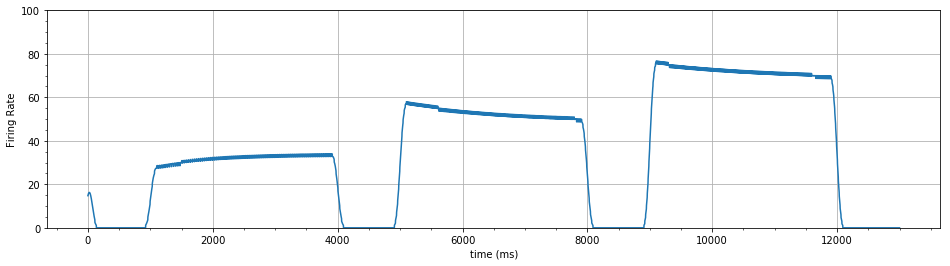

In [9]:
# PostI_rate
plot_vars(PostI_statemon, PostI_rate,  n, m, show_variables = False)

# Intact model

In [38]:
from brian2 import *
import numpy as np
import pickle
# prefs.devices.cpp_standalone.openmp_threads = 80
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [39]:
# common part of equations for different populations
from brian2 import *
import numpy as np
import pickle
import pandas as pd
start_scope()


eqs_general = '''
dv/dt = (- INa  -INaP - IK - ICaL - ICaT - IK_Ca - Il - IsynE - IsynI + Iapp)/C :volt #+
Iapp : amp
ENa = 55*mV :volt #+
EK = -94*mV :volt #+
C = 36*pF :farad #+
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp #+
dmK/dt = (m_inf_K - mK)/tau_mK :1 #+
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1    #+  
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1 #+
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1 #+
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second #+
tau_mK_max = 1*ms :second #+
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp #+

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1 #+
tau_hNa = tau_hNa_max/cosh((v + 67.5*mV)/(12.8*mV)) :second  #+
h_inf_Na = 1/(1+exp((v+67.5*mV)/(10.8*mV))) :1 #+
tau_hNa_max = 8.456*ms :second #+

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1 #+
m_inf_Na = 1/(1+exp(-(v+ 43.8*mV)/(6*mV))) :1 #+
tau_mNa =  tau_mNa_max/cosh(-(v+ 43.8*mV)/(14*mV)) : second  #+
tau_mNa_max = 0.252*ms :second #+
'''

eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp #+

dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1 #+
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 #+ 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second  #+       
tau_mNaP_max = 1*ms :second #+

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1 #+
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1  #+
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second #+
tau_hNaP_max = 5000*ms :second #+

'''

eqs_Il = '''
Il = gl*(v-El) :amp #+
El : volt #+
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


# eqs_ICaL = '''
# ICaL = gCaL*mCaL*hCaL*(v-ECa) :amp #+

# dhCaL/dt = (h_inf_CaL - hCaL)/tau_hCaL :1 #+
# dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
# m_inf_CaL = 1/(1+exp(-(v+27.4*mV)/(5.7*mV))) :1 #+
# h_inf_CaL = 1/(1+exp((v+52.4*mV)/(5.2*mV))) :1 #+
# tau_mCaL = 0.5*ms :second #+
# tau_hCaL = 18*ms :second #+

# '''

# eqs_IK_Ca = '''
# IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

# dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
# alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
# beta_inf_K_Ca = 2.5 : 1 #+
# m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
# tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
# tau_mK_Ca_max = 1*ms :second      #+ (1-8)                                            

# Pb = B/(Ca+B+K) :1 #+
# ECa = 13.27*mV*log(4*mM/Ca_0) :volt #+
# dCa/dt =  (Ca_0 - Ca)/tau_Ca : mM  #+ 0*k_Ca*ICaL*(1-Pb) +
# tau_Ca = 500*ms :second 

# k_Ca = 5.18*10**(-9)*mM/(amp*second) : mM/amp/second #!!
# B = 0.030*mM : mM #+
# K = 0.001*mM : mM #+
# Ca_0 = (5*10**(-5))*mM : mM #+

# '''

# eqs_ICaT = '''
# mCaT : 1
# hCaT : 1
# '''

eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp #+
gE = 1*nS : siemens #+
gEd = 1*nS : siemens #+
tau_synE = 5*ms :second #+
EsynE = 0*mV :volt #+
dwE/dt = -wE/tau_synE :1  #from self #+


# IsynI current
IsynI = gsynI*(v-EsynI) : amp #+
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens #+
gId = 1*nS : siemens #+
gI = 1*nS : siemens #+
tau_synI = 15*ms :second #+
EsynI = -75*mV :volt #+
dwI_1/dt = -wI_1/tau_synI :1  #+
dwI_2/dt = -wI_2/tau_synI :1  #+
dwI_3/dt = -wI_3/tau_synI :1  #+
''' 
 
eqs = eqs_general + eqs_IK + eqs_INa + eqs_INaP + eqs_Il + eqs_IK_Ca + eqs_ICaL + eqs_syn + eqs_ICaT
        

In [40]:
N = 1 #number of neurons in a population
#################################################

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.27  + 0.3 + 0.55) :siemens # drive 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons 0.15
gK_Ca  = 0*nS : siemens
gCaL = 0*nS : siemens
gCaT = 0*nS : siemens
gNa = 170*nS :siemens
gNaP = 5*nS :siemens
gK = 180*nS :siemens
gl = 2.5*nS :siemens
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PreI.v = (-68+3*randn(1,N))*mV
PreI.El = (-68+0.136*randn(1,N))*mV #-68
PreI.mNaP = rand(1,N)
PreI.hNaP = rand(1,N)
PreI.hNa = rand(1,N)
PreI.mNa = rand(1,N)
PreI.mK = rand(1,N)

EarlyI1_eqs = eqs + '''
x : 1
gsynE = gE*(wE) + gEd*(0.8 + 0.8) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI1.v = (-60+0.3*randn(1,N))*mV
EarlyI1.El = (-60+0.093*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

AugE_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1 + 0.45) :siemens # 0 + 1 + 0.4
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

AugE = NeuronGroup(N, AugE_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
AugE.v = (-60+0.3*randn(1,N))*mV
AugE.El = (-60+0.093*randn(1,N))*mV 
AugE.mNaP = rand(1,N)
AugE.hNaP = rand(1,N)
AugE.hNa = rand(1,N)
AugE.mNa = rand(1,N)
AugE.mK = rand(1,N)
AugE.mK_Ca = rand(1,N)
AugE.mCaL = rand(1,N)
AugE.mCaT = rand(1,N)
AugE.hCaT = rand(1,N)
AugE.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

PostI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1.6) :siemens # 0 + 0 + 1.5
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI = NeuronGroup(N, PostI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PostI.v = (-60+0.3*randn(1,N))*mV
PostI.El = (-60+0.093*randn(1,N))*mV 
PostI.mNaP = rand(1,N)
PostI.hNaP = rand(1,N)
PostI.hNa = rand(1,N)
PostI.mNa = rand(1,N)
PostI.mK = rand(1,N)
PostI.mK_Ca = rand(1,N)
PostI.mCaL = rand(1,N)
PostI.mCaT = rand(1,N)
PostI.hCaT = rand(1,N)
PostI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [41]:
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)
AugE.Iapp = 0

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)
PostI.Iapp = 0

PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.5') #0.03
PreI_PreI.connect(p=1)
PreI_PreI.delay = 4*rand(1,N)*ms

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 3') 
PostI_PreI.connect(p=1)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 2') #0.025
AugE_PreI.connect(p=1)

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 2') #0.034
PreI_EarlyI1.connect(p=1)#monitorings, spikes etc.

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_1_post += 3.3') 
PostI_EarlyI1.connect(p=1)

AugE_EarlyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_2_post += 2.3') #0.025 0.145
AugE_EarlyI1.connect(p=1)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_1_post += 3.3') 
PostI_AugE.connect(p=1)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_2_post += 3.0') # 0.02 0.115
EarlyI1_AugE.connect(p=1)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 3') 
EarlyI1_PostI.connect(p=1)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 1.9') #
AugE_PostI.connect(p=1)


In [42]:
duration = 35000
run(35000*ms, report='text')

Starting simulation at t=0. s for a duration of 35. s
1.8491 s (5%) simulated in 10s, estimated 2m 59s remaining.
3.2717 s (9%) simulated in 20s, estimated 3m 14s remaining.
4.1596 s (11%) simulated in 30s, estimated 3m 43s remaining.
5.1835 s (14%) simulated in 40s, estimated 3m 50s remaining.
6.5854 s (18%) simulated in 50s, estimated 3m 36s remaining.
7.2179 s (20%) simulated in 1m 0s, estimated 3m 51s remaining.
7.873 s (22%) simulated in 1m 10s, estimated 4m 1s remaining.
8.6235 s (24%) simulated in 1m 20s, estimated 4m 5s remaining.
9.458 s (27%) simulated in 1m 30s, estimated 4m 3s remaining.
10.3934 s (29%) simulated in 1m 40s, estimated 3m 57s remaining.
11.4767 s (32%) simulated in 1m 50s, estimated 3m 46s remaining.
13.0973 s (37%) simulated in 2m 0s, estimated 3m 21s remaining.
13.5187 s (38%) simulated in 2m 10s, estimated 3m 27s remaining.
13.9388 s (39%) simulated in 2m 20s, estimated 3m 32s remaining.
14.3752 s (41%) simulated in 2m 30s, estimated 3m 35s remaining.
14.8

In [43]:
n = (15.0/duration)*1000
m = 1.0

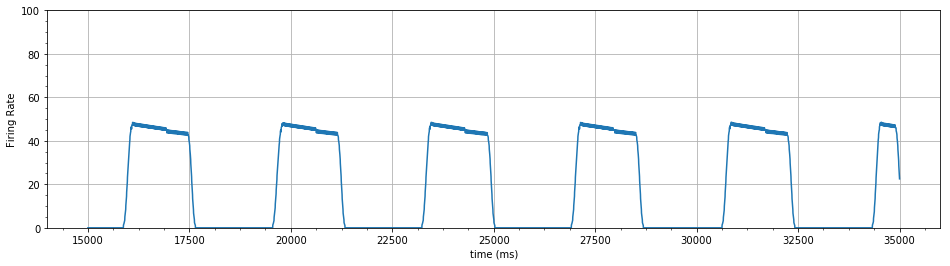

In [44]:
### AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

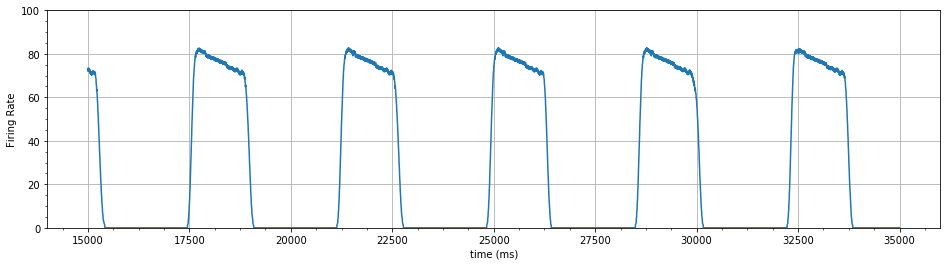

In [45]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

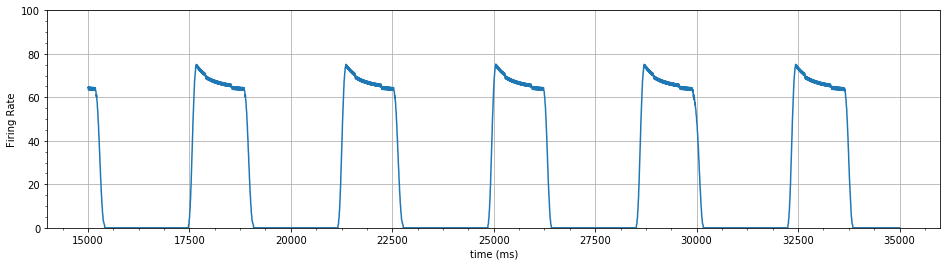

In [46]:
# PreI_rate
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = False)

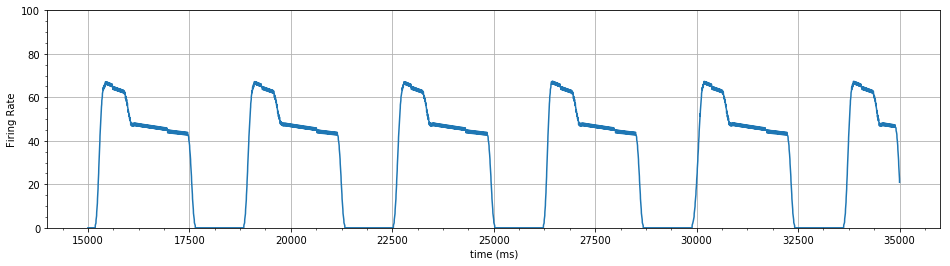

In [47]:
plot_vars(PostI_statemon, PostI_rate,  n, m, show_variables = False)

# Full model

In [55]:
from brian2 import *
import numpy as np
import pickle
# prefs.devices.cpp_standalone.openmp_threads = 80
prefs.codegen.target = 'cython'  # use the Python fallback
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 50*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [56]:
# common part of equations for different populations
from brian2 import *
import numpy as np
import pickle
import pandas as pd
start_scope()


eqs_general = '''
dv/dt = (- INa  -INaP - IK - ICaL - ICaT - IK_Ca - Il - IsynE - IsynI + Iapp)/C :volt #+
Iapp : amp
ENa = 55*mV :volt #+
EK = -94*mV :volt #+
C = 36*pF :farad #+
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp #+
dmK/dt = (m_inf_K - mK)/tau_mK :1 #+
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1    #+  
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1 #+
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1 #+
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second #+
tau_mK_max = 1*ms :second #+
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp #+

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1 #+
tau_hNa = tau_hNa_max/cosh((v + 67.5*mV)/(12.8*mV)) :second  #+
h_inf_Na = 1/(1+exp((v+67.5*mV)/(10.8*mV))) :1 #+
tau_hNa_max = 8.456*ms :second #+

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1 #+
m_inf_Na = 1/(1+exp(-(v+ 43.8*mV)/(6*mV))) :1 #+
tau_mNa =  tau_mNa_max/cosh(-(v+ 43.8*mV)/(14*mV)) : second  #+
tau_mNa_max = 0.252*ms :second #+
'''

eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp #+

dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1 #+
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 #+ 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second  #+       
tau_mNaP_max = 1*ms :second #+

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1 #+
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1  #+
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second #+
tau_hNaP_max = 5000*ms :second #+

'''

eqs_Il = '''
Il = gl*(v-El) :amp #+
El : volt #+
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


# eqs_ICaL = '''
# ICaL = gCaL*mCaL*hCaL*(v-ECa) :amp #+

# dhCaL/dt = (h_inf_CaL - hCaL)/tau_hCaL :1 #+
# dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
# m_inf_CaL = 1/(1+exp(-(v+27.4*mV)/(5.7*mV))) :1 #+
# h_inf_CaL = 1/(1+exp((v+52.4*mV)/(5.2*mV))) :1 #+
# tau_mCaL = 0.5*ms :second #+
# tau_hCaL = 18*ms :second #+

# '''

# eqs_IK_Ca = '''
# IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

# dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
# alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
# beta_inf_K_Ca = 2.5 : 1 #+
# m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
# tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
# tau_mK_Ca_max = 1*ms :second      #+ (1-8)                                            

# Pb = B/(Ca+B+K) :1 #+
# ECa = 13.27*mV*log(4*mM/Ca_0) :volt #+
# dCa/dt =  (Ca_0 - Ca)/tau_Ca : mM  #+ 0*k_Ca*ICaL*(1-Pb) +
# tau_Ca = 500*ms :second 

# k_Ca = 5.18*10**(-9)*mM/(amp*second) : mM/amp/second #!!
# B = 0.030*mM : mM #+
# K = 0.001*mM : mM #+
# Ca_0 = (5*10**(-5))*mM : mM #+

# '''

# eqs_ICaT = '''
# mCaT : 1
# hCaT : 1
# '''

eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp #+
gE = 1*nS : siemens #+
gEd = 1*nS : siemens #+
tau_synE = 5*ms :second #+
EsynE = 0*mV :volt #+
dwE/dt = -wE/tau_synE :1  #from self #+


# IsynI current
IsynI = gsynI*(v-EsynI) : amp #+
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens #+
gId = 1*nS : siemens #+
gI = 1*nS : siemens #+
tau_synI = 15*ms :second #+
EsynI = -75*mV :volt #+
dwI_1/dt = -wI_1/tau_synI :1  #+
dwI_2/dt = -wI_2/tau_synI :1  #+
dwI_3/dt = -wI_3/tau_synI :1  #+
''' 
 
eqs = eqs_general + eqs_IK + eqs_INa + eqs_INaP + eqs_Il + eqs_IK_Ca + eqs_ICaL + eqs_syn + eqs_ICaT

In [57]:
N = 1 #number of neurons in a population
#################################################

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.27  + 0.3 + 0.55) :siemens # drive 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons 0.15
gK_Ca  = 0*nS : siemens
gCaL = 0*nS : siemens
gCaT = 0*nS : siemens
gNa = 170*nS :siemens
gNaP = 5*nS :siemens
gK = 180*nS :siemens
gl = 2.5*nS :siemens
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PreI.v = (-68+3*randn(1,N))*mV
PreI.El = (-68+0.136*randn(1,N))*mV #-68
PreI.mNaP = rand(1,N)
PreI.hNaP = rand(1,N)
PreI.hNa = rand(1,N)
PreI.mNa = rand(1,N)
PreI.mK = rand(1,N)

EarlyI1_eqs = eqs + '''
x : 1
gsynE = gE*(wE) + gEd*(0.8 + 0.8) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI1.v = (-60+0.3*randn(1,N))*mV
EarlyI1.El = (-60+0.093*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

AugE_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1 + 0.45) :siemens # 0 + 1 + 0.4
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

AugE = NeuronGroup(N, AugE_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
AugE.v = (-60+0.3*randn(1,N))*mV
AugE.El = (-60+0.093*randn(1,N))*mV 
AugE.mNaP = rand(1,N)
AugE.hNaP = rand(1,N)
AugE.hNa = rand(1,N)
AugE.mNa = rand(1,N)
AugE.mK = rand(1,N)
AugE.mK_Ca = rand(1,N)
AugE.mCaL = rand(1,N)
AugE.mCaT = rand(1,N)
AugE.hCaT = rand(1,N)
AugE.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

PostI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1.6) :siemens # 0 + 0 + 1.5
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI = NeuronGroup(N, PostI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PostI.v = (-60+0.3*randn(1,N))*mV
PostI.El = (-60+0.093*randn(1,N))*mV 
PostI.mNaP = rand(1,N)
PostI.hNaP = rand(1,N)
PostI.hNa = rand(1,N)
PostI.mNa = rand(1,N)
PostI.mK = rand(1,N)
PostI.mK_Ca = rand(1,N)
PostI.mCaL = rand(1,N)
PostI.mCaT = rand(1,N)
PostI.hCaT = rand(1,N)
PostI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

PostI_e_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.3) :siemens  # 0 + 0 + 2
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI_e = NeuronGroup(N, PostI_e_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PostI_e.v = (-60+3*randn(1,N))*mV
PostI_e.El = (-60+0.093*randn(1,N))*mV 
PostI_e.mNaP = rand(1,N)
PostI_e.hNaP = rand(1,N)
PostI_e.hNa = rand(1,N)
PostI_e.mNa = rand(1,N)
PostI_e.mK = rand(1,N)
PostI_e.mK_Ca = rand(1,N)
PostI_e.mCaL = rand(1,N)
PostI_e.mCaT = rand(1,N)
PostI_e.hCaT = rand(1,N)
PostI_e.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

RampI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.5) :siemens  # 0 + 0 + 2
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

RampI = NeuronGroup(N, RampI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
RampI.v = (-60+3*randn(1,N))*mV
RampI.El = (-60+0.093*randn(1,N))*mV 
RampI.mNaP = rand(1,N)
RampI.hNaP = rand(1,N)
RampI.hNa = rand(1,N)
RampI.mNa = rand(1,N)
RampI.mK = rand(1,N)
RampI.mK_Ca = rand(1,N)
RampI.mCaL = rand(1,N)
RampI.mCaT = rand(1,N)
RampI.hCaT = rand(1,N)
RampI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

EarlyI2_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.7) :siemens # 0 + 0 + 1.7
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI2 = NeuronGroup(N, EarlyI2_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI2.v = (-60+0.3*randn(1,N))*mV
EarlyI2.El = (-60+0.093*randn(1,N))*mV 
EarlyI2.mNaP = rand(1,N)
EarlyI2.hNaP = rand(1,N)
EarlyI2.hNa = rand(1,N)
EarlyI2.mNa = rand(1,N)
EarlyI2.mK = rand(1,N)
EarlyI2.mK_Ca = rand(1,N)
EarlyI2.mCaL = rand(1,N)
EarlyI2.mCaT = rand(1,N)
EarlyI2.hCaT = rand(1,N)
EarlyI2.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [58]:
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)
AugE.Iapp = 0

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)
PostI.Iapp = 0

EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI2_spikemon = SpikeMonitor(EarlyI2)
EarlyI2_rate = PopulationRateMonitor(EarlyI2)
EarlyI2.Iapp = 0

RampI_statemon = StateMonitor(RampI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
RampI_spikemon = SpikeMonitor(RampI)
RampI_rate = PopulationRateMonitor(RampI)
RampI.Iapp = 0

PostI_e_statemon = StateMonitor(PostI_e, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_e_spikemon = SpikeMonitor(PostI_e)
PostI_e_rate = PopulationRateMonitor(PostI_e)
PostI_e.Iapp = 0


PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.5') #0.03
PreI_PreI.connect(p=1)
PreI_PreI.delay = 4*rand(1,N)*ms

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 3') 
PostI_PreI.connect(p=1)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 2') #0.025
AugE_PreI.connect(p=1)

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 2') #0.034
PreI_EarlyI1.connect(p=1)#monitorings, spikes etc.

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_1_post += 3.3') 
PostI_EarlyI1.connect(p=1)

AugE_EarlyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_2_post += 2.3') #0.025 0.145
AugE_EarlyI1.connect(p=1)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_1_post += 3.3') 
PostI_AugE.connect(p=1)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_2_post += 3.0') # 0.02 0.115
EarlyI1_AugE.connect(p=1)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 3') 
EarlyI1_PostI.connect(p=1)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 1.9') #
AugE_PostI.connect(p=1)


############################

AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 3') 
AugE_PostI_e.connect(p=1)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 3') 
EarlyI1_PostI_e.connect(p=1)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_post += 3') 
PreI_RampI.connect(p=1)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 3') 
AugE_RampI.connect(p=1)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 3.5') 
PostI_RampI.connect(p=1)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 3.5') 
EarlyI2_RampI.connect(p=1)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 3.5') 
AugE_EarlyI2.connect(p=1)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 3.5') 
PostI_EarlyI2.connect(p=1)


In [59]:
duration = 25000
run(25000*ms, report='text')


Starting simulation at t=0. s for a duration of 25. s
0.9455 s (3%) simulated in 10s, estimated 4m 14s remaining.
1.6713 s (6%) simulated in 20s, estimated 4m 39s remaining.
2.2604 s (9%) simulated in 30s, estimated 5m 2s remaining.
3.0061 s (12%) simulated in 40s, estimated 4m 53s remaining.
3.6325 s (14%) simulated in 50s, estimated 4m 54s remaining.
4.1477 s (16%) simulated in 1m 0s, estimated 5m 2s remaining.
4.6892 s (18%) simulated in 1m 10s, estimated 5m 3s remaining.
5.3326 s (21%) simulated in 1m 20s, estimated 4m 55s remaining.
5.997 s (23%) simulated in 1m 30s, estimated 4m 45s remaining.
6.6937 s (26%) simulated in 1m 40s, estimated 4m 34s remaining.
7.0441 s (28%) simulated in 1m 50s, estimated 4m 40s remaining.
7.4137 s (29%) simulated in 2m 0s, estimated 4m 45s remaining.
7.7752 s (31%) simulated in 2m 10s, estimated 4m 48s remaining.
8.1581 s (32%) simulated in 2m 20s, estimated 4m 49s remaining.
8.561 s (34%) simulated in 2m 30s, estimated 4m 48s remaining.
8.9751 s (3

In [60]:
n = (10.0/duration)*1000
m = 1.0

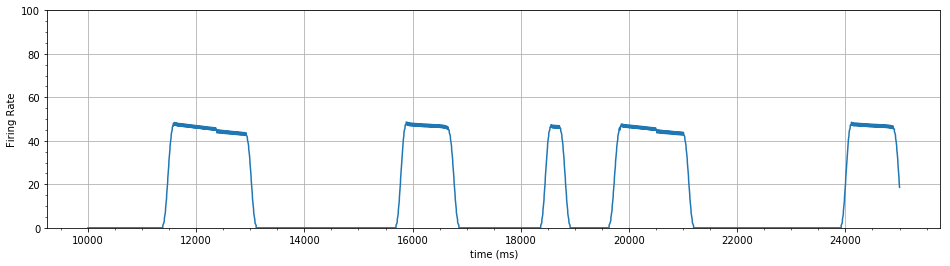

In [61]:
### AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

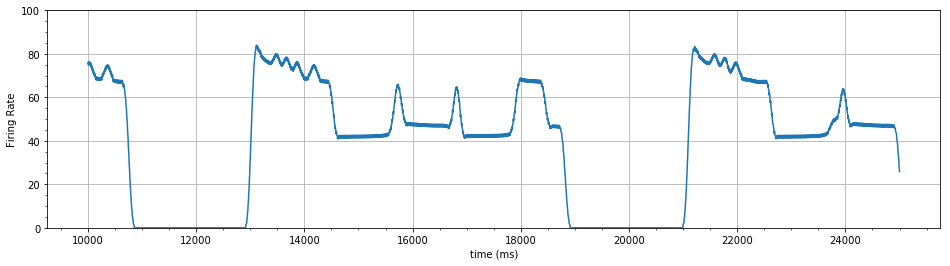

In [62]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

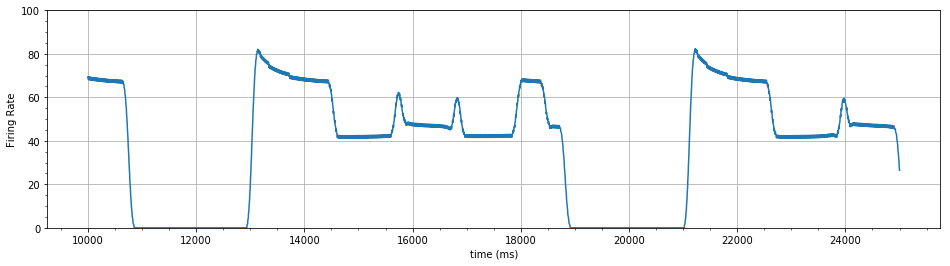

In [63]:
# PreI_rate
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = False)

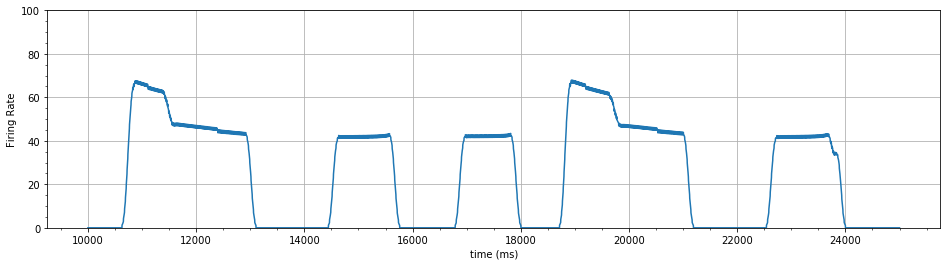

In [64]:
plot_vars(PostI_statemon, PostI_rate,  n, m, show_variables = False)

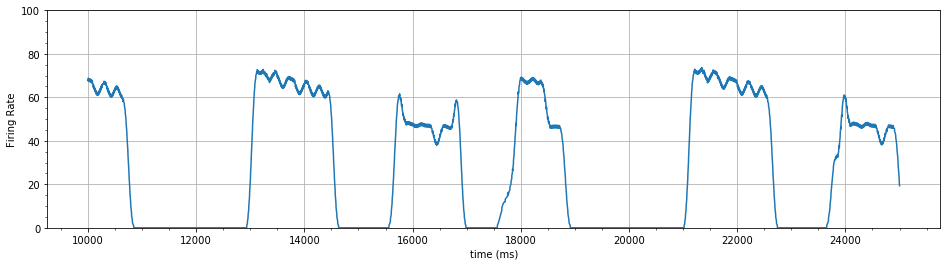

In [65]:
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)

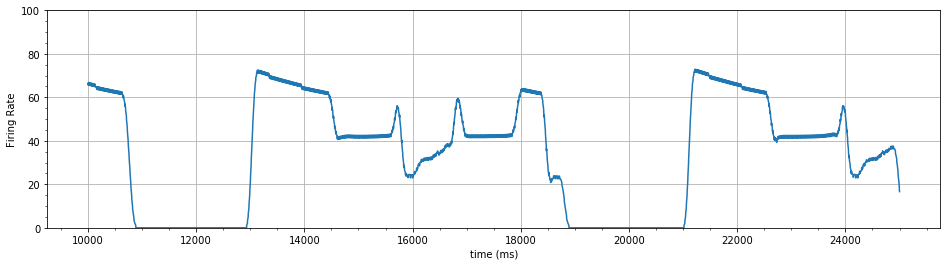

In [66]:
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)

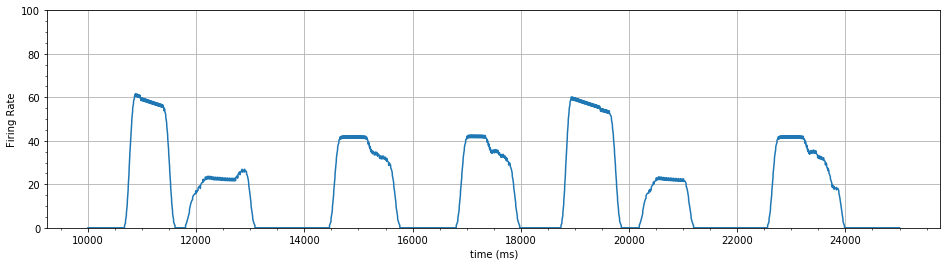

In [67]:
plot_vars(PostI_e_statemon, PostI_e_rate,  n, m, show_variables = False)

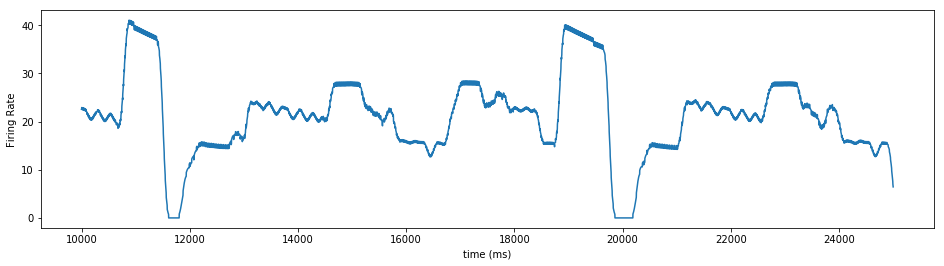

In [68]:
#cVN
#2/3 PostI_e 1/3 rampI (or PreI)

output_cVN = (2.0/3.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz+(1.0/3.0)*RampI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

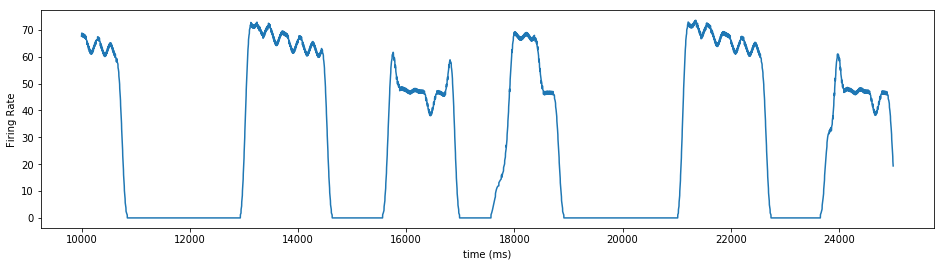

In [69]:
#PN
#PreI, or RampI

output_PN = RampI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

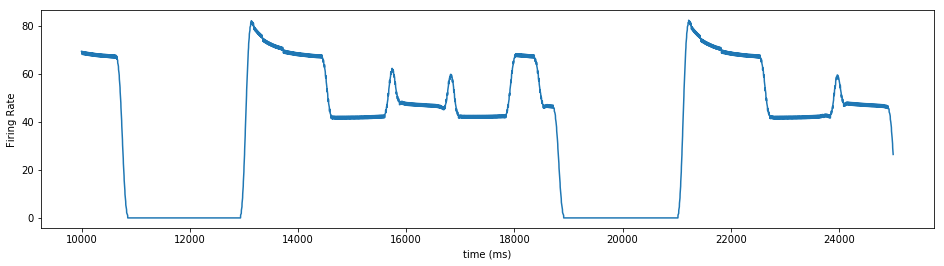

In [70]:
#HN
#PreI
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

# Scaling up the network

In [17]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone')
#prefs.codegen.target = 'cython'  # use the Python fallback
# prefs.devices.cpp_standalone.openmp_threads = 80
start_scope()



def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 25*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,100])
#     ylim([0,1.5*np.max(rate.smooth_rate(window='flat', width= 40*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()

In [2]:
# common part of equations for different populations


eqs_general = '''
dv/dt = (- INa  -INaP - IK - ICaL - ICaT - IK_Ca - Il - IsynE - IsynI + Iapp)/C :volt #+
Iapp : amp
ENa = 55*mV :volt #+
EK = -94*mV :volt #+
C = 36*pF :farad #+
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp #+
dmK/dt = (m_inf_K - mK)/tau_mK :1 #+
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1    #+  
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1 #+
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1 #+
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second #+
tau_mK_max = 1*ms :second #+
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp #+

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1 #+
tau_hNa = tau_hNa_max/cosh((v + 67.5*mV)/(12.8*mV)) :second  #+
h_inf_Na = 1/(1+exp((v+67.5*mV)/(10.8*mV))) :1 #+
tau_hNa_max = 8.456*ms :second #+

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1 #+
m_inf_Na = 1/(1+exp(-(v+ 43.8*mV)/(6*mV))) :1 #+
tau_mNa =  tau_mNa_max/cosh(-(v+ 43.8*mV)/(14*mV)) : second  #+
tau_mNa_max = 0.252*ms :second #+
'''

eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp #+

dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1 #+
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 #+ 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second  #+       
tau_mNaP_max = 1*ms :second #+

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1 #+
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1  #+
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second #+
tau_hNaP_max = 5000*ms :second #+

'''

eqs_Il = '''
Il = gl*(v-El) :amp #+
El : volt #+
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


# eqs_ICaL = '''
# ICaL = gCaL*mCaL*hCaL*(v-ECa) :amp #+

# dhCaL/dt = (h_inf_CaL - hCaL)/tau_hCaL :1 #+
# dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
# m_inf_CaL = 1/(1+exp(-(v+27.4*mV)/(5.7*mV))) :1 #+
# h_inf_CaL = 1/(1+exp((v+52.4*mV)/(5.2*mV))) :1 #+
# tau_mCaL = 0.5*ms :second #+
# tau_hCaL = 18*ms :second #+

# '''

# eqs_IK_Ca = '''
# IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

# dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
# alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
# beta_inf_K_Ca = 2.5 : 1 #+
# m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
# tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
# tau_mK_Ca_max = 1*ms :second      #+ (1-8)                                            

# Pb = B/(Ca+B+K) :1 #+
# ECa = 13.27*mV*log(4*mM/Ca_0) :volt #+
# dCa/dt =  (Ca_0 - Ca)/tau_Ca : mM  #+ 0*k_Ca*ICaL*(1-Pb) +
# tau_Ca = 500*ms :second 

# k_Ca = 5.18*10**(-9)*mM/(amp*second) : mM/amp/second #!!
# B = 0.030*mM : mM #+
# K = 0.001*mM : mM #+
# Ca_0 = (5*10**(-5))*mM : mM #+

# '''

# eqs_ICaT = '''
# mCaT : 1
# hCaT : 1
# '''

eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp #+
gE = 1*nS : siemens #+
gEd = 1*nS : siemens #+
tau_synE = 5*ms :second #+
EsynE = 0*mV :volt #+
dwE/dt = -wE/tau_synE :1  #from self #+


# IsynI current
IsynI = gsynI*(v-EsynI) : amp #+
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens #+
gId = 1*nS : siemens #+
gI = 1*nS : siemens #+
tau_synI = 15*ms :second #+
EsynI = -75*mV :volt #+
dwI_1/dt = -wI_1/tau_synI :1  #+
dwI_2/dt = -wI_2/tau_synI :1  #+
dwI_3/dt = -wI_3/tau_synI :1  #+
''' 
 
eqs = eqs_general + eqs_IK + eqs_INa + eqs_INaP + eqs_Il + eqs_IK_Ca + eqs_ICaL + eqs_syn + eqs_ICaT
        

In [3]:
    N = 50 #number of neurons in a population
#################################################

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.27  + 0.3 + 0.65) :siemens # drive 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons 0.15
gK_Ca  = 0*nS : siemens
gCaL = 0*nS : siemens
gCaT = 0*nS : siemens
gNa = 170*nS :siemens
gNaP = 5*nS :siemens
gK = 180*nS :siemens
gl = 2.5*nS :siemens
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PreI.v = (-68+3*randn(1,N))*mV
PreI.El = (-68+1.36*randn(1,N))*mV #-68
PreI.mNaP = rand(1,N)
PreI.hNaP = rand(1,N)
PreI.hNa = rand(1,N)
PreI.mNa = rand(1,N)
PreI.mK = rand(1,N)

EarlyI1_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.8 + 0.8) :siemens # 0 + 0.7 + 1.1
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI1 = NeuronGroup(N, EarlyI1_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI1.v = (-60+3*randn(1,N))*mV
EarlyI1.El = (-60+0.93*randn(1,N))*mV 
EarlyI1.mNaP = rand(1,N)
EarlyI1.hNaP = rand(1,N)
EarlyI1.hNa = rand(1,N)
EarlyI1.mNa = rand(1,N)
EarlyI1.mK = rand(1,N)
EarlyI1.mK_Ca = rand(1,N)
EarlyI1.mCaL = rand(1,N)
EarlyI1.mCaT = rand(1,N)
EarlyI1.hCaT = rand(1,N)
EarlyI1.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

AugE_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1 + 0.30) :siemens # 0 + 1 + 0.4
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

AugE = NeuronGroup(N, AugE_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
AugE.v = (-60+3*randn(1,N))*mV
AugE.El = (-60+0.93*randn(1,N))*mV 
AugE.mNaP = rand(1,N)
AugE.hNaP = rand(1,N)
AugE.hNa = rand(1,N)
AugE.mNa = rand(1,N)
AugE.mK = rand(1,N)
AugE.mK_Ca = rand(1,N)
AugE.mCaL = rand(1,N)
AugE.mCaT = rand(1,N)
AugE.hCaT = rand(1,N)
AugE.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

PostI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(1.65) :siemens # 0 + 0 + 1.5
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gCaT = 0*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI = NeuronGroup(N, PostI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PostI.v = (-60+3*randn(1,N))*mV
PostI.El = (-60+0.93*randn(1,N))*mV 
PostI.mNaP = rand(1,N)
PostI.hNaP = rand(1,N)
PostI.hNa = rand(1,N)
PostI.mNa = rand(1,N)
PostI.mK = rand(1,N)
PostI.mK_Ca = rand(1,N)
PostI.mCaL = rand(1,N)
PostI.mCaT = rand(1,N)
PostI.hCaT = rand(1,N)
PostI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

PostI_e_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.2) :siemens  # 0 + 0 + 2
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

PostI_e = NeuronGroup(N, PostI_e_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
PostI_e.v = (-60+3*randn(1,N))*mV
PostI_e.El = (-60+0.93*randn(1,N))*mV 
PostI_e.mNaP = rand(1,N)
PostI_e.hNaP = rand(1,N)
PostI_e.hNa = rand(1,N)
PostI_e.mNa = rand(1,N)
PostI_e.mK = rand(1,N)
PostI_e.mK_Ca = rand(1,N)
PostI_e.mCaL = rand(1,N)
PostI_e.mCaT = rand(1,N)
PostI_e.hCaT = rand(1,N)
PostI_e.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

RampI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.5) :siemens  # 0 + 0 + 2
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

RampI = NeuronGroup(N, RampI_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
RampI.v = (-60+3*randn(1,N))*mV
RampI.El = (-60+0.93*randn(1,N))*mV 
RampI.mNaP = rand(1,N)
RampI.hNaP = rand(1,N)
RampI.hNa = rand(1,N)
RampI.mNa = rand(1,N)
RampI.mK = rand(1,N)
RampI.mK_Ca = rand(1,N)
RampI.mCaL = rand(1,N)
RampI.mCaT = rand(1,N)
RampI.hCaT = rand(1,N)
RampI.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

EarlyI2_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0 + 0 + 1.5) :siemens # 0 + 0 + 1.7
gK_Ca  = 20.0*nS : siemens
gCaL = 5*nS : siemens
gNa = 400*nS :siemens
gNaP = 0*nS :siemens
gK = 250*nS :siemens
gl = 6*nS :siemens
'''

EarlyI2 = NeuronGroup(N, EarlyI2_eqs,method='exponential_euler', threshold='v >= -35*mV',refractory='v >= -35*mV') 
EarlyI2.v = (-60+3*randn(1,N))*mV
EarlyI2.El = (-60+0.93*randn(1,N))*mV 
EarlyI2.mNaP = rand(1,N)
EarlyI2.hNaP = rand(1,N)
EarlyI2.hNa = rand(1,N)
EarlyI2.mNa = rand(1,N)
EarlyI2.mK = rand(1,N)
EarlyI2.mK_Ca = rand(1,N)
EarlyI2.mCaL = rand(1,N)
EarlyI2.mCaT = rand(1,N)
EarlyI2.hCaT = rand(1,N)
EarlyI2.Ca = (5*10**(-5))*mM*(0.1*randn(1,N)+1)

In [4]:
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)
EarlyI1.Iapp = 0

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)
AugE.Iapp = 0

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)
PostI.Iapp = 0

EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI2_spikemon = SpikeMonitor(EarlyI2)
EarlyI2_rate = PopulationRateMonitor(EarlyI2)
EarlyI2.Iapp = 0

RampI_statemon = StateMonitor(RampI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
RampI_spikemon = SpikeMonitor(RampI)
RampI_rate = PopulationRateMonitor(RampI)
RampI.Iapp = 0

PostI_e_statemon = StateMonitor(PostI_e, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_e_spikemon = SpikeMonitor(PostI_e)
PostI_e_rate = PopulationRateMonitor(PostI_e)
PostI_e.Iapp = 0

PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.01') #0.03
PreI_PreI.connect(p=1)

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 0.06') 
PostI_PreI.connect(p=1)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 0.04') #0.025
AugE_PreI.connect(p=1)

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 0.04') #0.034
PreI_EarlyI1.connect(p=1)#monitorings, spikes etc.

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_1_post += 0.07') 
PostI_EarlyI1.connect(p=1)

AugE_EarlyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_2_post += 0.05') #0.025 0.145
AugE_EarlyI1.connect(p=1)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_1_post += 0.06') #0.06 17/01/2018 
PostI_AugE.connect(p=1)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_2_post += 0.065') # 0.02 0.115
EarlyI1_AugE.connect(p=1)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 0.06') 
EarlyI1_PostI.connect(p=1)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 0.06') #
AugE_PostI.connect(p=1)

######################################################

AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 0.06') 
AugE_PostI_e.connect(p=1)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 0.06') 
EarlyI1_PostI_e.connect(p=1)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_post += 0.06') 
PreI_RampI.connect(p=1)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 0.06') 
AugE_RampI.connect(p=1)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 0.06') 
PostI_RampI.connect(p=1)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 0.06') 
EarlyI2_RampI.connect(p=1)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 0.06') 
AugE_EarlyI2.connect(p=1)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 0.06') 
PostI_EarlyI2.connect(p=1)


In [5]:
duration = 25000
run(25000*ms, report='text')

WARNING    neurongroup_1's variable 'mCaL' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'hNa' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'mCaT' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'mK_Ca' 

In [6]:
n = (15.0/duration)*1000
m = 1.0

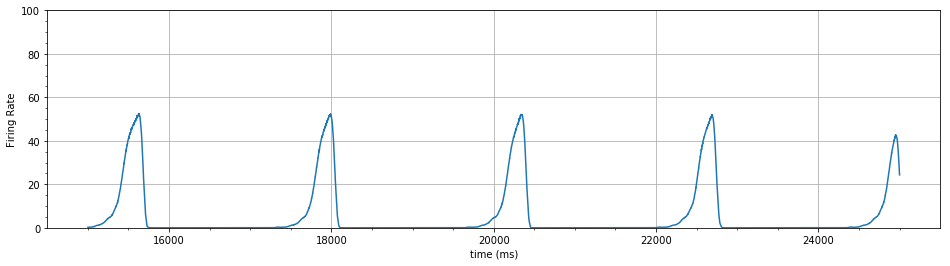

In [18]:
### AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

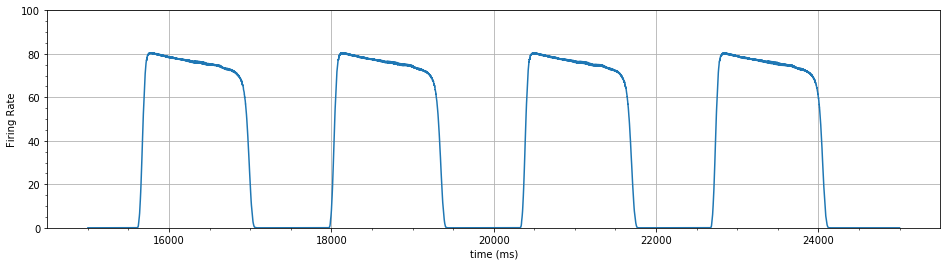

In [19]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

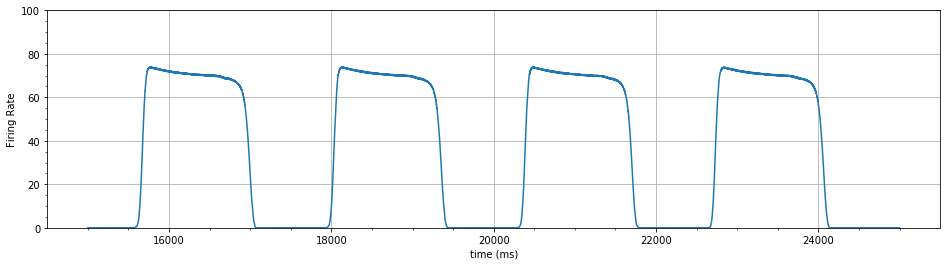

In [20]:
# PreI_rate
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = False)

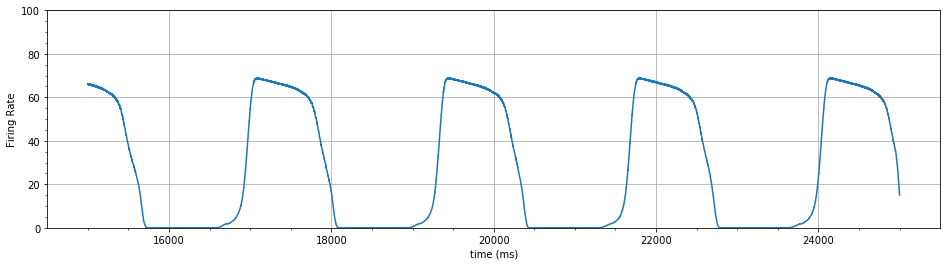

In [21]:
plot_vars(PostI_statemon, PostI_rate,  n, m, show_variables = False)

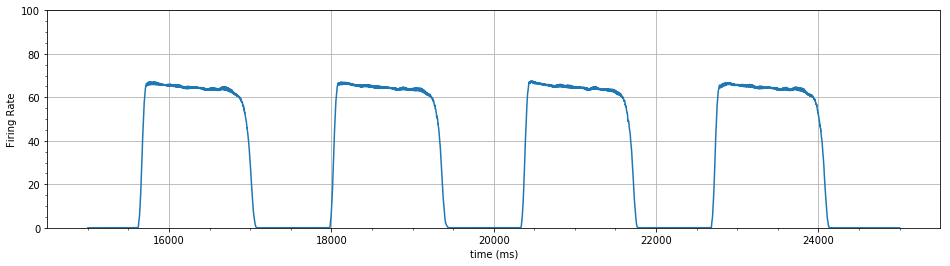

In [22]:
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)

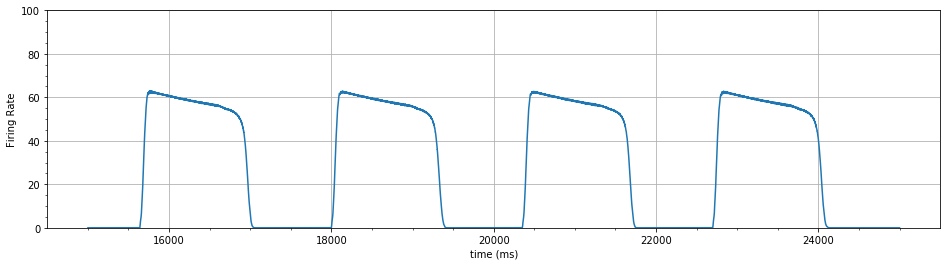

In [23]:
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)

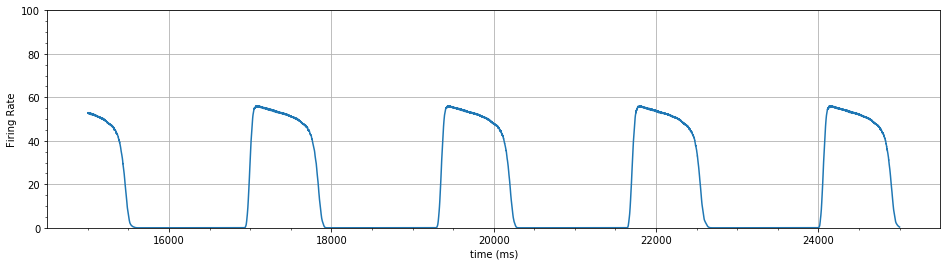

In [24]:
plot_vars(PostI_e_statemon, PostI_e_rate,  n, m, show_variables = False)

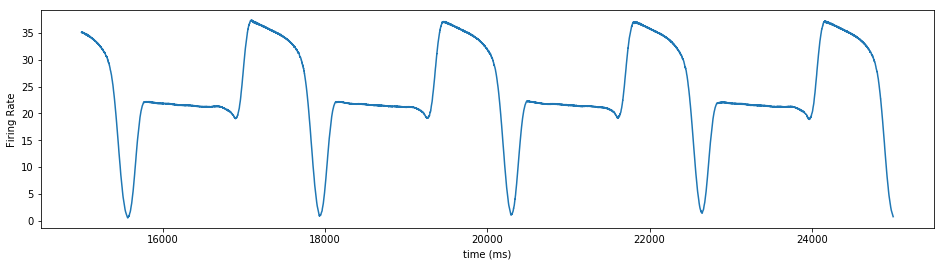

In [25]:
#cVN
#2/3 PostI_e 1/3 rampI (or PreI)

output_cVN = (2.0/3.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz+(1.0/3.0)*RampI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

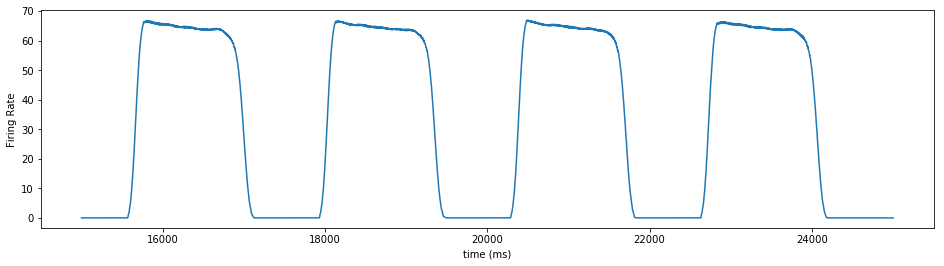

In [26]:
#PN
#PreI, or RampI

output_PN = RampI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

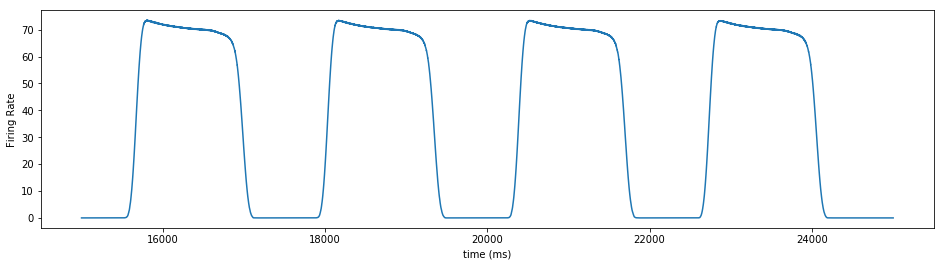

In [27]:
#HN
#PreI
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 50*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

In [10]:
# common part of equations for different populations


eqs_general = '''
dv/dt = (- INa  -INaP - IK  - Il - IsynE - IsynI - ICaL - IK_Ca + Iapp)/C :volt #
Iapp : amp
ENa = 55*mV :volt
EK = -94*mV :volt
C = 36*pF :farad
'''


eqs_IK = '''
IK = gK*(mK**4)*(v-EK) :amp
dmK/dt = (m_inf_K - mK)/tau_mK :1
alpha_inf_K = 0.01*(mV**-1)*(v+44*mV)/(1-exp(-(v+44*mV)/(5*mV))) :1     
beta_inf_K = 0.17*exp(-(v+49*mV)/(40*mV)) :1
m_inf_K = alpha_inf_K/(alpha_inf_K+beta_inf_K) :1
tau_mK = tau_mK_max/(alpha_inf_K+beta_inf_K) :second
tau_mK_max = 1*ms :second
'''

eqs_INa = '''
INa = gNa*(mNa**3)*hNa*(v-ENa) :amp

dhNa/dt = (h_inf_Na - hNa)/tau_hNa :1
tau_hNa = tau_hNa_max/cosh((v+hNa_v_half*mV)/(tauhNa_var*mV)) :second
h_inf_Na = 1/(1+exp((v+hNa_v_half*mV)/(hNa_k*mV))) :1
hNa_v_half = 67.5 : 1
hNa_k = 10.8 :1
tau_hNa_max = 8.456*ms :second
tauhNa_var  = 12.8 :1
mNa_v_half = 43.8 :1
mNa_k = 6 :1
taumNa_var = 14:1

dmNa/dt = (m_inf_Na - mNa)/tau_mNa :1
m_inf_Na = 1/(1+exp(-(v+mNa_v_half*mV)/(mNa_k*mV))) :1
tau_mNa =  tau_mNa_max/cosh(-(v+mNa_v_half*mV)/(taumNa_var*mV)) : second  
tau_mNa_max = 0.252*ms :second
'''


eqs_INaP = '''
INaP = gNaP*mNaP*hNaP*(v-ENa) :amp

dhNaP/dt = (h_inf_NaP - hNaP)/tau_hNaP :1
dmNaP/dt = (m_inf_NaP - mNaP)/tau_mNaP :1
m_inf_NaP = 1/(1+exp(-(v+47.1*mV)/(3.1*mV))) :1 
tau_mNaP = tau_mNaP_max/cosh(+(v+47.1*mV)/(6.2*mV)) :second         
tau_mNaP_max = 1*ms :second
h_inf_NaP = 1/(1+exp((v+60*mV)/(9*mV))) :1 
tau_hNaP = tau_hNaP_max/cosh((v+60*mV)/(9*mV)) :second 
tau_hNaP_max = 5000*ms :second #6000

'''

eqs_Il = '''
Il = gl*(v-El) :amp
El : volt
'''

eqs_ICaT = '''
# IK_Ca, ICaL currents

ICaT = gCaL*(mCaT**2)*hCaT*(v-ECa) :amp #+

dmCaT/dt = (m_inf_CaT - mCaT)/tau_mCaT :1 #+
m_inf_CaT = 1/(1+exp(-(v/mV + 60.5)/6.2)) :1 #+
tau_mCaT = (0.612 + 1/(1+exp(-(v/mV+131.6)/16.7)) + exp((v/mV + 16.8)/18.2))*ms :second #+
dhCaT/dt = (h_inf_CaT - hCaT)/tau_hCaT :1 #+
h_inf_CaT = 1/(1+exp((v/mV + 84.5)/4.03)) :1 #+
tau_hCaT = (28 + exp(-(v/mV + 21.88)/10.52))*ms :second #+
'''

eqs_ICaL = '''
ICaL = gCaL*(mCaL**2)*(v-ECa) :amp #+

dmCaL/dt = (m_inf_CaL - mCaL)/tau_mCaL :1 #+
alpha_inf_CaL = 1.6/(1+exp(-0.072*(v-5*mV)/mV)) :1 
beta_inf_CaL = 0.02*(v/mV - 1.31)/(exp((v/mV-1.31)/5.36) - 1) : 1 #+
m_inf_CaL = alpha_inf_CaL / (alpha_inf_CaL + beta_inf_CaL) :1 #+
tau_mCaL = 1*ms/(alpha_inf_CaL + beta_inf_CaL) :second #+
'''

eqs_IK_Ca = '''
IK_Ca = gK_Ca*(mK_Ca**2)*(v-EK) :amp

dmK_Ca/dt = (m_inf_K_Ca - mK_Ca)/tau_mK_Ca :1 #+
alpha_inf_K_Ca = 1.25*(10**8)*(Ca)**2 /(mM**2) :1 #+?
beta_inf_K_Ca = 2.5 : 1 #+
m_inf_K_Ca = alpha_inf_K_Ca/(alpha_inf_K_Ca + beta_inf_K_Ca) :1 #+
tau_mK_Ca = tau_mK_Ca_max * 1000/(alpha_inf_K_Ca + beta_inf_K_Ca) :second #+
tau_mK_Ca_max = 6*ms :second      #+ (1-8)                                            

dCa/dt = (-(ICaL+ICaT)/(2*F*vol))*(1-Pb) + (Ca_0 - Ca)/tau_pump : mM  #+
Pb = B/(Ca+B+K) :1 #+
ECa = 13.27*mV*log(4*mM/Ca) :volt #+

F = 9.648*10**4*amp*second/mol : amp*second/mol
vol = 0.1*um*area : metre**3
area = C/(1*uF/cm**2) : metre**2
tau_pump = 17.7*ms*exp(v/(35*mV)) :second #+
B = 0.030*mM : mM #+
K = 0.001*mM : mM #+
Ca_0 = (5*10**(-5))*mM : mM #+

'''


eqs_syn='''
# IsynE current
IsynE = gsynE*(v-EsynE) : amp
gE = 1*nS : siemens
gEd = 1*nS : siemens
tau_synE = 30*ms :second
EsynE = 0*mV :volt
dwE/dt = -wE/tau_synE :1  #from self


# IsynI current
IsynI = gsynI*(v-EsynI) : amp
gsynI = (gI*(wI_1+wI_2+wI_3) + gId*(0.0)) : siemens
gId = 1*nS : siemens
gI = 1*nS : siemens
tau_synI = 15*ms :second
EsynI = -75*mV :volt
dwI_1/dt = -wI_1/tau_synI :1 
dwI_2/dt = -wI_2/tau_synI :1 
dwI_3/dt = -wI_3/tau_synI :1 
''' 
 
eqs = eqs_general+eqs_IK+eqs_INa+eqs_INaP+eqs_Il+ eqs_IK_Ca +eqs_ICaL+eqs_ICaT + eqs_syn
        

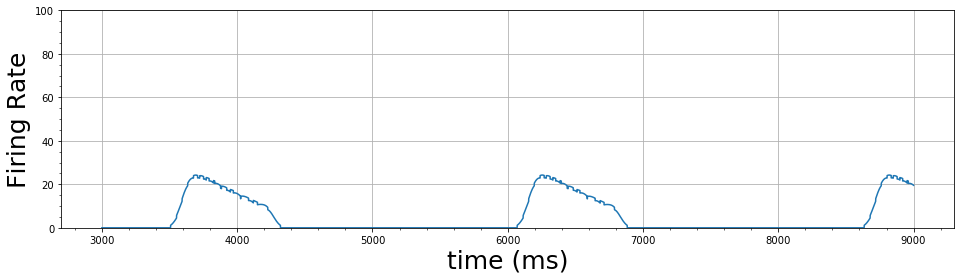

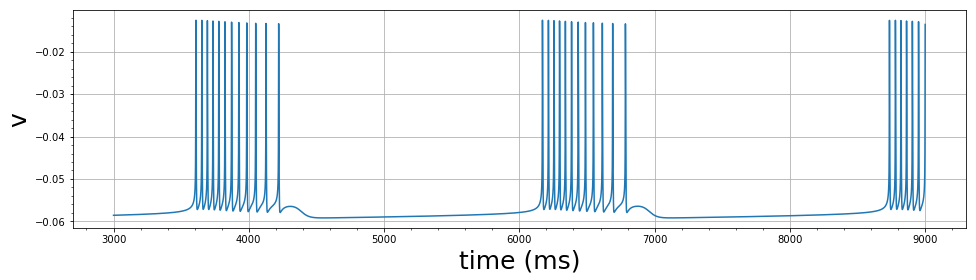

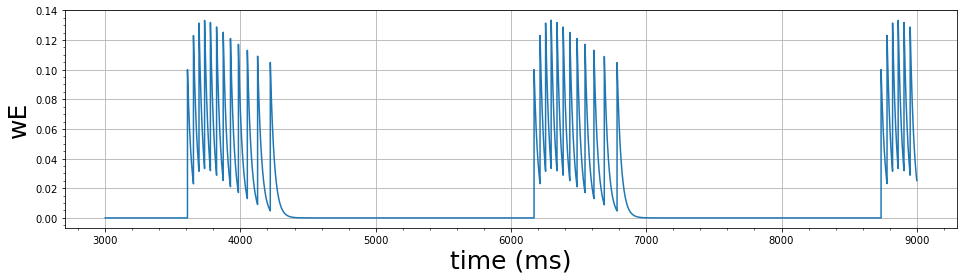

In [11]:
N = 1 #number of neurons in a population
#################################################
#adding specific equations for a population

PreI_eqs = eqs + '''
gsynE = gE*(wE) + gEd*(0.29) :siemens # 0.3 - preBotC, 0.13 - RTN/BotC, 0.55 - Pons #+ 0.28 is threshold 1 +0.4*t/60000/ms
gK_Ca  = 0*nS : siemens #+ +0.3*t/60000/ms
gCaL = 0*nS : siemens #+
gNa = 170*nS :siemens #+
gNaP = 5*nS :siemens #+
gK = 180*nS :siemens #+
gl = 2.5*nS :siemens #+
'''

PreI = NeuronGroup(N, PreI_eqs,method='exponential_euler', threshold='v >= -35*mV', refractory='v >= -35*mV') #+ 
PreI.v = (-68+10*randn(1,N))*mV 
PreI.El = (-68+0.136*randn(1,N))*mV  #+
PreI.mNaP = rand(1,N) #+
PreI.hNaP = rand(1,N) #+
PreI.hNa = rand(1,N) #+
PreI.mNa = rand(1,N) #+
PreI.mK = rand(1,N) #+

PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.1') #+
PreI_PreI.connect(p=1)
PreI_PreI.delay = 5*rand(1,N)*ms

PreI_statemon = StateMonitor(PreI, ['v','wE'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)
PreI.Iapp = 0

duration = 15000
run(duration*ms, report='text')

n = 0.20
m = 0.6

#PreI
plot_vars(PreI_statemon, PreI_rate,  n, m, show_variables = True)